In [2]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False
train_patches = False

In [3]:
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)
import os
import pydicom

Last run on Mon May  9 10:13:00 2022
TorchIO version: 0.18.57


In [4]:
def read_dicom_files(dicom_dir):
    try:
        # dicom_files = glob.glob(os.path.join(dicom_dir, "*.*"))
        dicom_files = [os.path.join(dicom_dir, dicom_file) for dicom_file in os.listdir(dicom_dir)]
        sorted_dicom_files = sorted(dicom_files)
        stacked_dicom = [pydicom.dcmread(dicom_file) for dicom_file in sorted_dicom_files]
        return stacked_dicom
    except IndexError as e:
        print(f"{e}, at path {dicom_dir}")
        return None

In [5]:
def create_3d_vol(path_dicom_A, path_dicom_B):
    orig_d_dicom_stacks = read_dicom_files(str(path_dicom_A))
    reg_d_dicom_stacks = read_dicom_files(str(path_dicom_B))

    image_shape_orig = list(orig_d_dicom_stacks[0].pixel_array.shape)
    image_shape_orig.append(len(orig_d_dicom_stacks))

    image_3d_orig = np.zeros(image_shape_orig)


    image_shape_reg = list(reg_d_dicom_stacks[0].pixel_array.shape)
    image_shape_reg.append(len(reg_d_dicom_stacks))

    image_3d_reg = np.zeros(image_shape_reg)

    for j in range(len(reg_d_dicom_stacks)):
        image_3d_orig[:, :, j] = orig_d_dicom_stacks[j].pixel_array
        image_3d_reg[:, :, j] = reg_d_dicom_stacks[j].pixel_array

    return image_3d_orig, image_3d_reg

In [6]:
path_A = '../exp_input_data/val/example_A/HCC_1174_d'
path_B = '../exp_input_data/val/example_B/HCC_1174_p'
image_A_3d, image_B_3d = create_3d_vol(path_A, path_B)
print(image_A_3d.shape)
print(np.expand_dims(image_B_3d, 0).shape)

(512, 512, 103)
(1, 512, 512, 103)


In [7]:
tensor_A = torch.from_numpy(np.expand_dims(image_A_3d, 0))
tensor_B = torch.from_numpy(np.expand_dims(image_B_3d, 0))
tensor_A.shape
# tensor_A.dtype

torch.Size([1, 512, 512, 103])

In [8]:
# image_A_dir = Path("./HCC_1174/P/input")
# image_B_dir = Path("./HCC_1174/D/input")
image_A_dir = Path("../exp_input_data/val/example_A")
image_B_dir = Path("../exp_input_data/val/example_B")
image_A_path = sorted(image_A_dir.glob('*.*'))
image_B_path = sorted(image_B_dir.glob('*.*'))
print(image_A_path)
print(image_B_path)
img_tio_A = tio.ScalarImage('../exp_input_data/val/example_A/HCC_1174_d')
img_tio_B = tio.ScalarImage('../exp_input_data/val/example_B/HCC_1174_p')

[]
[]


In [9]:
subjects = []
for i in range(2):
    subject = tio.Subject(moving = img_tio_A, fixed = img_tio_B)
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size', len(dataset), 'subjects')

Dataset size 2 subjects


# Plot one of the subject from the dataset

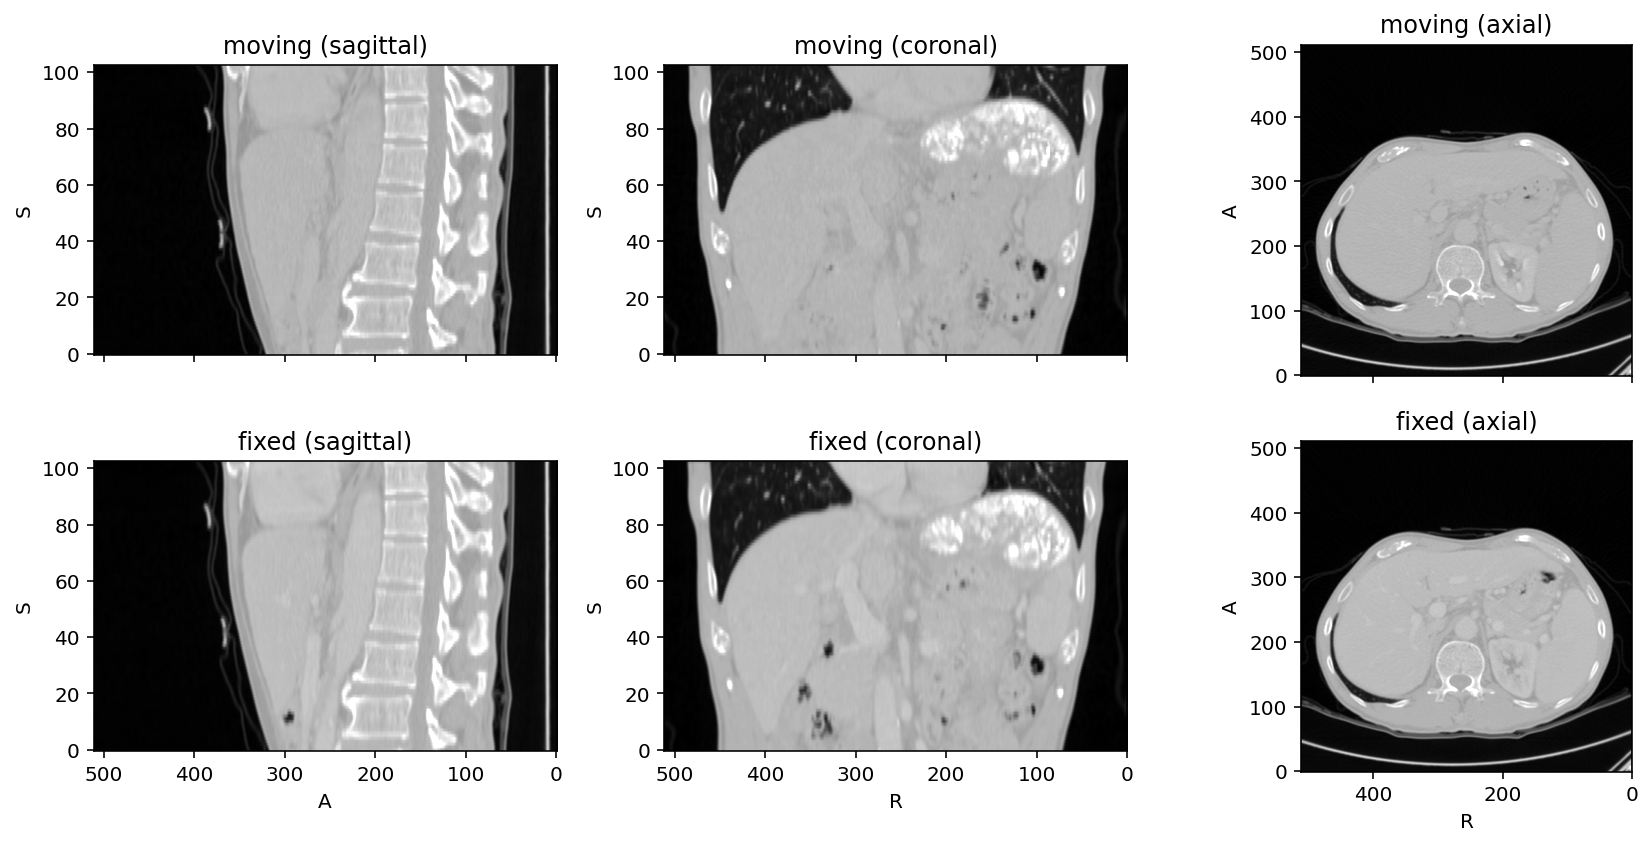

In [10]:
one_subject = dataset[0]
one_subject.plot()

In [33]:
print(one_subject)
print(one_subject.moving)
print(one_subject.fixed)
tensor = one_subject.get_images()[0].data
print(tensor.dtype)

Subject(Keys: ('moving', 'fixed'); images: 2)
ScalarImage(shape: (1, 512, 512, 103); spacing: (0.64, 0.64, 2.00); orientation: LPS+; dtype: torch.ShortTensor; memory: 51.5 MiB)
ScalarImage(shape: (1, 512, 512, 103); spacing: (0.64, 0.64, 2.00); orientation: LPS+; dtype: torch.ShortTensor; memory: 51.5 MiB)
torch.int16


# Set of available transformations <-- we do not use it in our example in here

In [11]:
# training_transform = tio.Compose([
#     tio.ToCanonical(),
#     tio.Resample(4),
#     tio.CropOrPad((48, 60, 48)),
#     tio.RandomMotion(p=0.2),
#     tio.HistogramStandardization({'mri': landmarks}),
#     tio.RandomBiasField(p=0.3),
#     tio.ZNormalization(masking_method=tio.ZNormalization.mean),
#     tio.RandomNoise(p=0.5),
#     tio.RandomFlip(),
#     tio.OneOf({
#         tio.RandomAffine(): 0.8,
#         tio.RandomElasticDeformation(): 0.2,
#     }),
#     tio.OneHot(),
# ])
#
# validation_transform = tio.Compose([
#     tio.ToCanonical(),
#     tio.Resample(4),
#     tio.CropOrPad((48, 60, 48)),
#     tio.HistogramStandardization({'mri': landmarks}),
#     tio.ZNormalization(masking_method=tio.ZNormalization.mean),
#     tio.OneHot(),
# ])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects
num_split_subjects = num_training_subjects, num_validation_subjects
print(num_training_subjects)
print(num_validation_subjects)

1
1


# Training and validation dataset

In [12]:
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)
train_set = tio.SubjectsDataset(training_subjects, transform=None)
val_set = tio.SubjectsDataset(validation_subjects, transform=None)
print('train set:', len(train_set), 'subjects')
print('val set:', len(val_set), 'subjects')


train set: 1 subjects
val set: 1 subjects


In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 1, shuffle = True, num_workers = 8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = 1, shuffle = True, num_workers = 8)

# Visualize axial axis of one batch

In [14]:
k = 24
one_batch = next(iter(train_loader))
batch_moving = one_batch['moving'][tio.DATA][...,k]
batch_fixed = one_batch['fixed'][tio.DATA][...,k] # for label (mask) use [:, 1:, ..., k]
slices = torch.cat((batch_moving, batch_fixed))
slices_fp32 = slices.type(torch.FloatTensor)
# slices_fp32.dtype
image_path = "io_batch_image_test.png"
torchvision.utils.save_image(slices_fp32, image_path, nrow=1, normalize = True, scale_each = True, padding = 0)


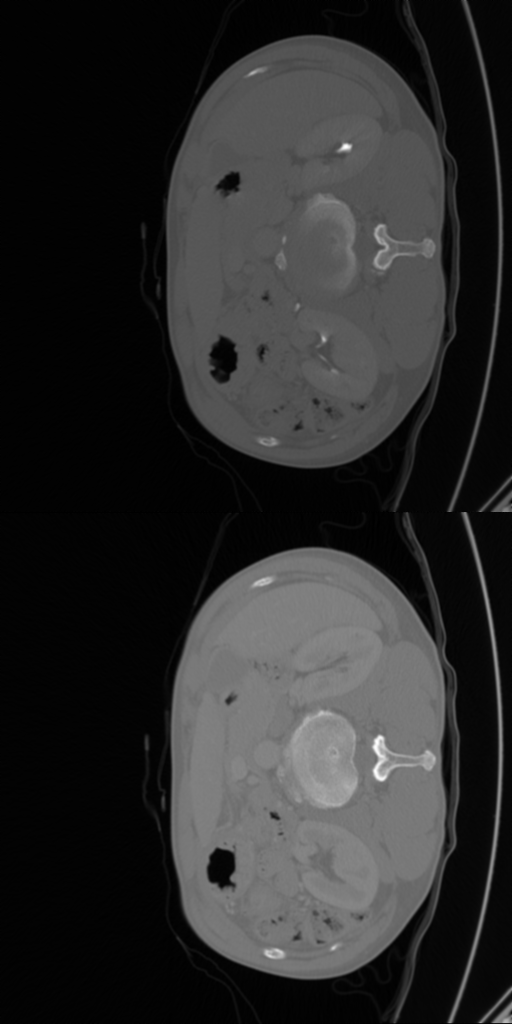

In [15]:
display.Image(image_path)

# Patch based

In [16]:
patch_size = (64,64,64)
max_queue_length = 3000
samples_per_volume = 5
sampler = tio.data.UniformSampler(patch_size)
patches_train_set = tio.Queue(subjects_dataset=train_set, max_length=max_queue_length, samples_per_volume=samples_per_volume, sampler = sampler,
                              num_workers = 8, shuffle_subjects = False, shuffle_patches = False,)

patches_val_set = tio.Queue(subjects_dataset=val_set, max_length=max_queue_length, samples_per_volume=samples_per_volume, sampler = sampler,
                              num_workers = 8, shuffle_subjects = False, shuffle_patches = False,)

In [20]:
batch_size_p = 4

train_loader_patches = torch.utils.data.DataLoader(patches_train_set, batch_size = batch_size_p)
val_loader_patches = torch.utils.data.DataLoader(patches_val_set, batch_size = batch_size_p)
print(len(train_loader_patches))

2


# Visualize axial slices of on batch

In [21]:
one_batch = next(iter(train_loader_patches))
k = int(24)
batch_moving = one_batch['moving'][tio.DATA][..., k]
print(batch_fixed.shape)
print(batch_moving.shape)
batch_fixed = one_batch['fixed'][tio.DATA][..., k]
slices = torch.cat((batch_moving, batch_fixed))
slices_fp32 = slices.type(torch.FloatTensor)
image_path = 'batch_patches.png'
torchvision.utils.save_image(slices_fp32, image_path, nrow=batch_size_p, normalize = True, scale_each = True, padding = 0)

torch.Size([5, 1, 64, 64])
torch.Size([4, 1, 64, 64])


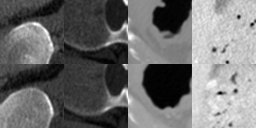

In [22]:
display.Image(image_path)

In [27]:
input_tensor = 48,48,48
patch_overlap = 4,4,4
grid_sampler = tio.GridSampler(one_subject, patch_size, patch_overlap, padding_mode=True)
print(grid_sampler)

In [26]:
print(len(grid_sampler))

162


In [45]:
batch_s = 1
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_s)

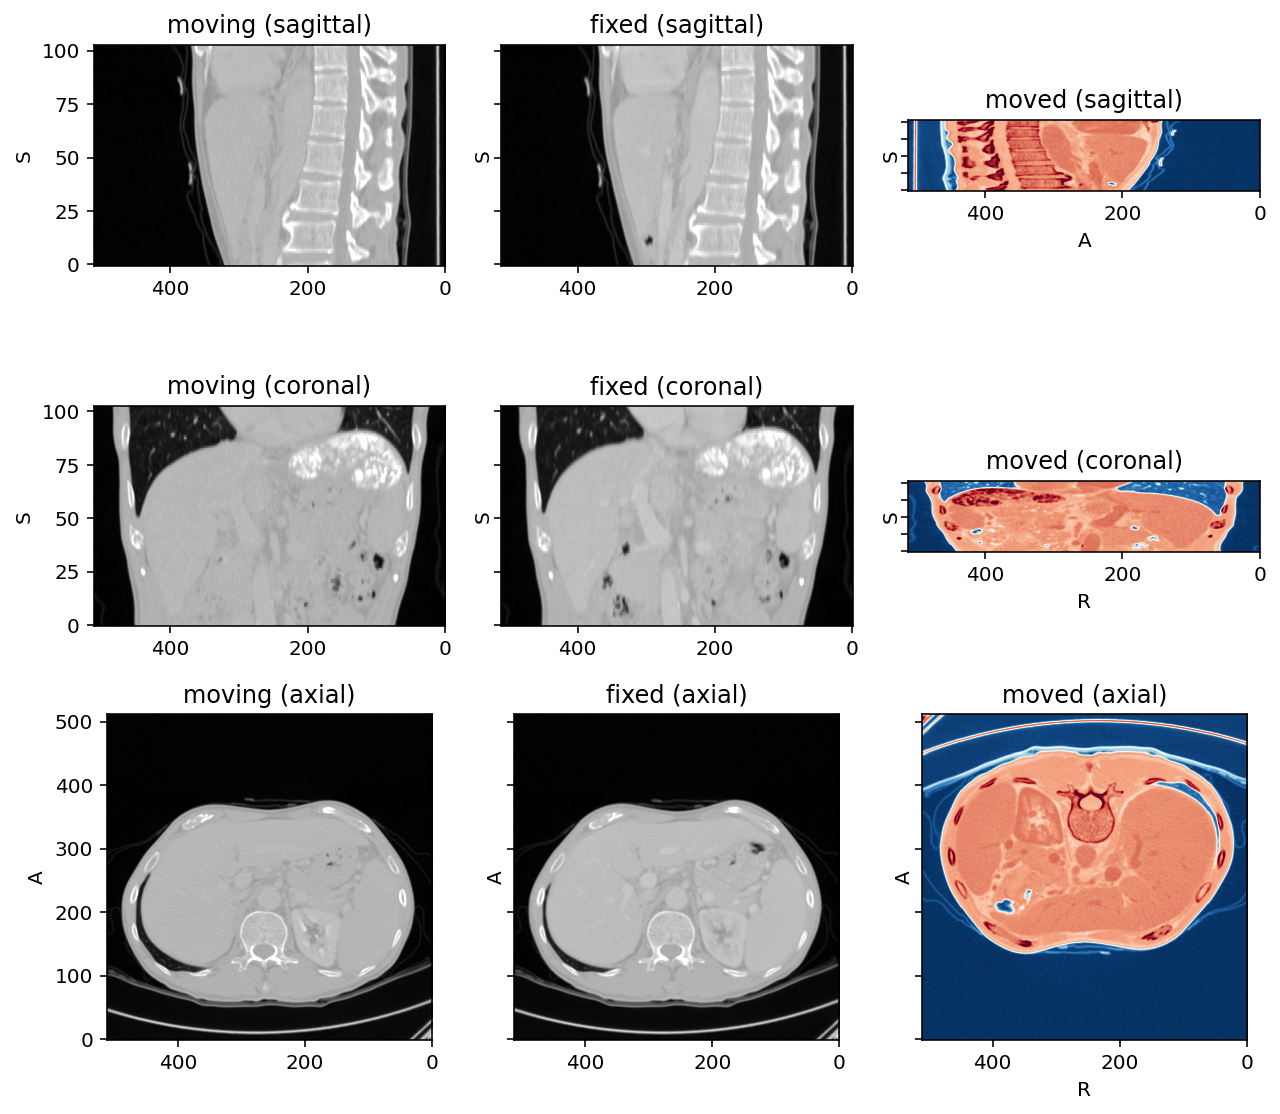

In [49]:
aggregator = tio.inference.GridAggregator(grid_sampler)
for patches_batch in patch_loader:
    inputs = patches_batch['moving'][tio.DATA]
    locations = patches_batch[tio.LOCATION]
    aggregator.add_batch(patches_batch['fixed'][tio.DATA], locations)
moved = aggregator.get_output_tensor()
moved_mv = tio.ScalarImage(tensor=moved)
one_subject.add_image(moved_mv, "moved")
one_subject.plot(figsize = (9,8), cmap_dict = {'moved': 'RdBu_r'})

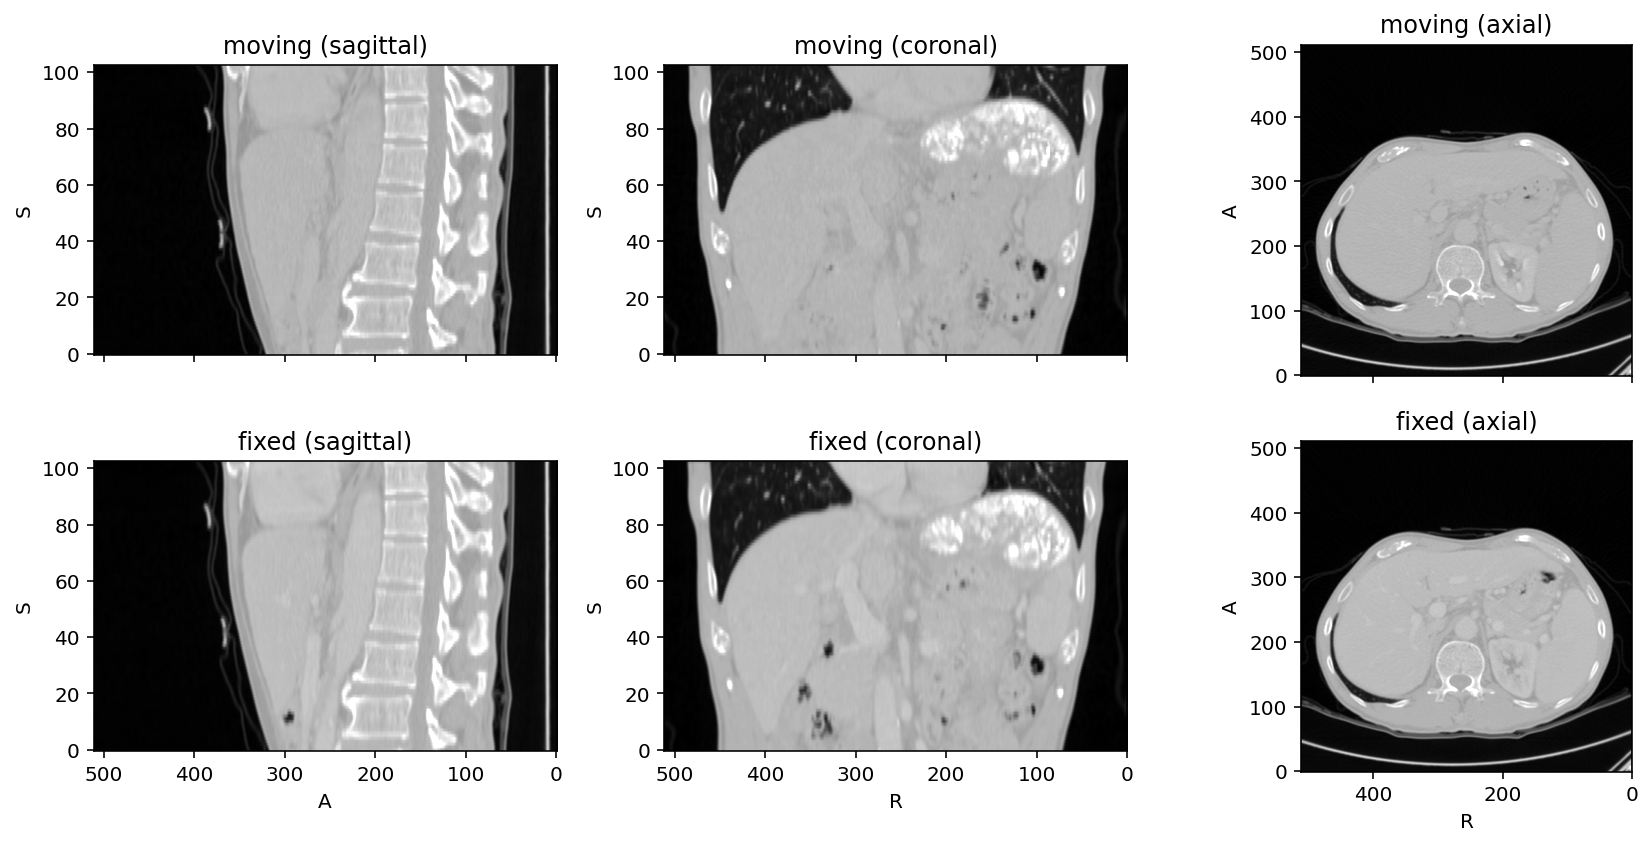

In [48]:
one_subject.plot()